Nuclear Feature Extractions 
=========================

This notebook will cover the steps in extracting nuclear features for all the masks from the hemotyxolin stained(nuclei stained), grayscaled images. 

The pipeline is summarized below:
1. Before going into the codes, the user should specify the directories for:
    - root_dir : current working directory where we could locate pickle_helper, feature_extraction
    - masks_dir : directory where the individual masks are located 
    - tiles_dir : directory where the H&E stained pickled object is located
    - 
2. Load the hemotyxolin stained images(gray scaled) for all the tiles:
    - In our case, the hemotyxolin stained images are stored in the pickle files, consisting of 3 arrays. 
        - First element in the array: dict of gray images with blue channels with key=index_position, value=img
        - Second element in the array: dict of gray images with red channels with key=index_position, value=img
        - Third element in the array: list of corresponding tile names  
    - If there's no pickle object generated, please refer to the code in `PREPROCESSING` to perform color deconvolution on RGB tiles. As a result, this should output a pickle object consist of 3 elements: hemotoxylin images, eosin images, tile_names. 
    
3. Load the individual masks for all the tiles:
4. For each tile, feed in the 2D mask, hemoxylin image, `tile_name`, and `save_dir` to the feature_extraction function. It will store all the extracted_features under the `save_dir/tile_name.csv`.

In [4]:
import matplotlib.pyplot as plt
from skimage import feature
from scipy import ndimage as ndi 
import pandas as pd
import numpy as np
import cv2 as cv
import SimpleITK as sitk
import skimage, imageio, importlib, pickle, time, os, statistics, sys,six

In [26]:
#This is a function that we will import from the current directory,
#make sure pickle_helper.py is under current working_directory
import pickle_helper
import Segmented_result_Samir.nuclei_feature_extraction as extract

1.Define Constants for Directories  
===================================

In [25]:
#change your directory if needed 
#os.chdir('../')

os.getcwd()

'/home/ruiqi/BE223B(nucleus)'

***User would have to edit the directory below***

An example of the directories 
-------------------------------------------------------------

In [15]:
#define the constants for dir folders and filenames
tiles_dir = './tiles_rois'
masks_dir = './Segmented_result_Samir/masks'
masks_coordinate_dir = './Segmented_result_Samir/masks_coord' 
root_dir = './Segmented_result_Samir'

-----------------------------------------------------------

In [22]:
#Run this by default
mask_files = os.listdir(masks_dir)
#get all the file names 
mask_name = list(map(lambda x: os.path.splitext(x)[0], mask_files))
#the following assumes first file is an extra file in my directory, 
#comment it out based on personal needs. 
mask_name.pop(0) 

#show the mask_name format 
mask_name[:5] 

['10009_49280_17920',
 '1001_74368_18816',
 '1002_2688_38528',
 '10044_91392_32256',
 '10070_5376_18816']

2.Load in grayscaled Hemoxylin stained image from H&E Pickle Object 
=====================================

This is the pickle object that contains all the H&E images using `Keane's PREPROCESSING CODE (EDIT needed)`. If the user wishes to use H&E from their own data, edit the filename for `he_img_file`.

In [14]:
he_img_file = 'PICKLE_FILE_HE_IMAGES.pck'

#edit the filename if user is generating H&E tiles using personal data.
#he_img_file = 'EDIT_HERE_IF_NEEDED.pck'

In [11]:
#the normalized_img has 3 arrays
#normalized_img[0]: dict of gray images with blue channels with key=index_position, value=img
#normalized_img[1]: dict of gray images with red channels with key=index_position, value=img
#noramlized_img[2]: list of tile names corresponding 
he_img_path = os.path.join(tiles_dir, he_img_file)
infile2 = open(he_img_path,'rb')
normalized_img = pickle.load(infile2, encoding='bytes')

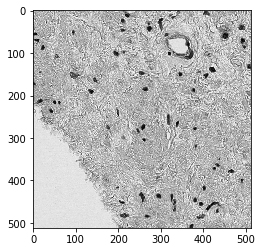

In [23]:
# The following is an illustration of the nuclei stained image for
# mask_name[0]
plt.imshow(pickle_helper.lookup(normalized_img,mask_name[0]), cmap='gray')

3.Nuclear Feature Extraction
===============================

Utilize the pyradiomics library to generate features
-------------------------------------------------------
reference:
   - [compute a pyradiomics object](https://pyradiomics.readthedocs.io/en/latest/radiomics.html#module-radiomics.featureextractor)
   - [SimplelTK Object Type](http://simpleitk.github.io/SimpleITK-Notebooks/01_Image_Basics.html) 
       changing the np.array / list type to simplel object

finished function:
- reconstruct_mask (coord)
- extract_features_from_mask_helper (image, mask) #used pyradiomcs
- extract_features_from_masks (img_matrix, maskDir, maskExt, mask_name, saveDir):#compute features for all masks for one file
- main:
    generate features for all files (if given the normalized file)

in_progress:
- Select Important Features from the generated features


In [29]:
#reload if `extract` is updated  
importlib.reload(extract)

<module 'Segmented_result_Samir.nuclei_feature_extraction' from '/home/ruiqi/BE223B(nucleus)/Segmented_result_Samir/nuclei_feature_extraction.py'>

**Define the constants(edit base on needs)**


In [ ]:
img_ext = '' #need to specify img_ext
mask_ext = '.csv'
save_dir= os.path.join(root_dir,'masks_features') #save to directory

To replicate feature_extraction, feel free to run the codes below 
--------------------------------------------------------------------------------------

In [32]:
#main

#try if mask has problems
error_file = []
sitkError_files = []
loadmaskError_files = []
saveError_files = []
extractError_files = []
concatError_files = []

SITKERROR = str(999)
MASKERROR = str(990)
SAVEERROR = str(980)
EXTRACTERROR = str(970)
CONCATERROR = str(960)

log_error = pd.DataFrame()
for file in known_otherError_files:
    print(file)
    #he_image is a matrix that represents the image for that mask
    #mask is just a file name, not necessarily a mask matrix 
    he_image = pickle_helper.lookup(normalized_img, file)   
    try:    
        dim_error_files, other_error_files = extract.extract_features_from_masks(he_image, masks_dir, mask_ext, file, save_dir)
        #print(dim_error_files, other_error_files)
        error_division = pd.DataFrame(data={'dim_error': np.NaN, 'other_error': np.NaN}, index = [file], dtype = object)
        if len(dim_error_files) > 0:
            error_division.at[file, 'dim_error'] = np.array(dim_error_files)
        if len(other_error_files) > 0:
            error_division.at[file, 'other_error'] = np.array(other_error_files)
        log_error = pd.concat([log_error, error_division])
        
    except BaseException as e:
        error_type = str(e)
        print(file, " has an error type of ", error_type)
        if error_type == SITKERROR:
            sitkError_files.append(file)
        elif error_type == MASKERROR:
            loadmaskError_files.append(file)
        elif error_type == SAVEERROR: 
            saveError_files.append(file)
        elif error_type == EXTRACTERROR: 
            extractError_files.append(file)
        elif error_type == CONCATERROR:
            concatError_files.append(file)
        else: 
            error_file.append(file)
    #error_division = pd.DataFrame({'dim_error': dim_error_files, 'other_error': other_error_files}, index = [file])
    #log_error = pd.concat([log_error, error_division])
        
#    except:
#        print("cannot find features for ", mask )
#        error_file.append(mask)
       
#print("sitkError_files are : \n ", sitkError_files, "\n\n")
#print("loadmaskError_files are : \n ", loadmaskError_files, "\n\n")
#print("saveError_files are : \n ",saveError_files, "\n\n")
#print("extractError_files are : \n ", extractError_files, "\n\n")
#print("concatError_files are : \n ", concatError_files, "\n\n")
#print("other error files are : \n ", error_file)
log_error.to_csv(os.path.join(bug_dir, 'other_bug_file_logs' + '.csv'))

10398_84224_18816
Finished extracting features for  10398_84224_18816 . 
Total time lapsed =  10.66472578048706
10656_93184_30464
Finished extracting features for  10656_93184_30464 . 
Total time lapsed =  9.897942304611206
12028_50176_9856
Finished extracting features for  12028_50176_9856 . 
Total time lapsed =  11.781207799911499
12047_90496_11648
Finished extracting features for  12047_90496_11648 . 
Total time lapsed =  8.414220094680786
12146_87808_21504
Finished extracting features for  12146_87808_21504 . 
Total time lapsed =  6.317068815231323
13028_101248_18816
Finished extracting features for  13028_101248_18816 . 
Total time lapsed =  7.748347282409668
1325_24192_9856
Finished extracting features for  1325_24192_9856 . 
Total time lapsed =  14.072373867034912
1383_88704_29568
Finished extracting features for  1383_88704_29568 . 
Total time lapsed =  17.39668560028076
14370_71680_16128
Finished extracting features for  14370_71680_16128 . 
Total time lapsed =  8.328521966934

**Use this to debug if needed**


In [14]:
#load in wrong files
bug_dir = os.path.join(root_dir,'bug_groups')
successfullyExtractedFeatures = os.listdir(save_dir)
successfullyExtractedFeatures.pop(0)
num_success_files = len(successfullyExtractedFeatures)
error_files_1 = np.load(os.path.join(bug_dir,'all_bug_files.npy'))
known_extractError_files = np.load(os.path.join(bug_dir,'featureExtract_bug_files.npy'))
known_otherError_files = np.load(os.path.join(bug_dir,'other_bug_files.npy'))

For users who wanted to load the generated features
-------------------------------------------------------

In [31]:
saved_files = os.listdir(save_dir)
saved_files.pop(0)
df = pd.read_csv(os.path.join(save_dir,saved_files[0]))

In [33]:
df

,mask_num,diagnostics_Mask-original_CenterOfMass,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0,"(455.52830188679246, 394.47169811320754)","(512, 512)",186.895012,14,255,4cb74953ea53ac412aa19a8363df5a0425624885,"(1.0, 1.0)","(512, 512)","(452, 391, 8, 8)",...,13.065476,0.115527,3.209208,0.792453,0.240930,0.653266,0.101923,12.481069,0.139303,1.129306
1,1,"(445.968253968254, 380.1587301587302)","(512, 512)",186.895012,14,255,93161b2add8f4c8a01e38b1a3d07f7ca4de0acaa,"(1.0, 1.0)","(512, 512)","(441, 377, 11, 7)",...,8.232639,0.095142,3.265957,0.634921,0.394375,0.524840,0.096183,9.157615,0.050613,1.110016
2,2,"(185.45945945945945, 263.2972972972973)","(512, 512)",186.895012,14,255,b9914538aad3e6b89ca6fcd5900f64e24022d1c0,"(1.0, 1.0)","(512, 512)","(181, 259, 10, 9)",...,7.737587,0.136026,3.086395,0.689189,0.718185,1.025000,0.070780,6.651879,0.051065,0.500501
3,3,"(278.3888888888889, 380.0)","(512, 512)",186.895012,14,255,2b989bd325bbecd9ceb62cd23ece32eeca1927c7,"(1.0, 1.0)","(512, 512)","(276, 377, 6, 7)",...,8.755435,0.128260,3.273349,0.638889,0.854442,0.378106,0.147844,10.363759,0.049383,1.802469
4,4,"(150.0943396226415, 345.64150943396226)","(512, 512)",186.895012,14,255,4dfba0d165c1f6e96963e7a504d37414c8603b48,"(1.0, 1.0)","(512, 512)","(146, 343, 9, 7)",...,4.911411,0.152355,2.640301,0.698113,0.353543,2.417722,0.138743,2.566936,0.087717,0.690426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,110,"(61.375, 189.83333333333334)","(512, 512)",186.895012,14,255,10bdbdad85b12274c67d95226a49550042b243d8,"(1.0, 1.0)","(512, 512)","(57, 187, 10, 6)",...,6.799663,0.179347,3.164421,0.687500,0.490358,1.025485,0.113609,6.347553,0.076968,0.880952
111,111,"(42.319148936170215, 301.8085106382979)","(512, 512)",186.895012,14,255,7b1fac625b6e39f2827d975bcfbaff460236f502,"(1.0, 1.0)","(512, 512)","(37, 300, 12, 5)",...,1.302870,0.371143,2.858278,0.382979,4.682099,3.263636,0.130919,0.325034,0.065987,0.129032
112,112,"(4.384615384615385, 342.0769230769231)","(512, 512)",186.895012,14,255,3eb5a647c169f95938281832287d03f6ad38e3bd,"(1.0, 1.0)","(512, 512)","(1, 339, 7, 7)",...,0.822519,0.285782,2.873141,0.333333,4.153846,1.103175,0.280576,0.182774,0.021494,0.266667
113,113,"(68.24444444444444, 361.75555555555553)","(512, 512)",186.895012,14,255,35c687971ee8942d931a4a65dccb7d2e16a7d090,"(1.0, 1.0)","(512, 512)","(65, 359, 9, 7)",...,0.888520,0.234976,3.000000,0.355556,4.027344,2.343750,0.200000,0.222222,0.047627,0.200000
